### Table of contents:

* [Download data from CSV](#down)
* [Data cleaning](#cleaning)
* [Select companies in cybersecurity](#cyber)
* [Set limits](#set_limits)
* [Create graph](#create_graph)
* [Rank](#rank)
* [Parameters calibration with exogenous variables](#pal_cal)
* [b](#b)

In [188]:
import math
import arrow
import ipynb 
import os.path
import json
import pickle
import sys
import random
import operator

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import numpy as np

from dotenv import load_dotenv
from networkx.algorithms import bipartite
from importlib import reload
from typing import List


In [189]:
# import functions from py file 

import functions.fun
reload(functions.fun)
from functions.fun import CB_data_cleaning, df_from_api_CB, extract_nodes, extract_data_from_column
from functions.fun import nx_dip_graph_from_pandas, plot_bipartite_graph, filter_dict, check_desc
from functions.fun import extract_classes_company_tech, degree_bip, insert_data_classes

In [190]:
# import classes 

import classes
reload(classes)
#from classes import Company, Investor, Technology

<module 'classes' from '/home/anita.mezzetti/bipartite_network/classes.py'>

### Download data from CSV <a class="anchor" id="down"></a>

In [191]:
df_start = pd.read_csv("data/data_cb/organizations.csv")

In [192]:
df_start.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,legal_name,roles,...,phone,facebook_url,linkedin_url,twitter_url,logo_url,alias1,alias2,alias3,primary_role,num_exits
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,wetpaint,https://www.crunchbase.com/organization/wetpaint,158955.0,2007-05-25 13:51:27,2019-06-24 22:19:25,NaN,company,...,206-859-6300,https://www.facebook.com/Wetpaint,https://www.linkedin.com/company/wetpaint,https://twitter.com/wetpainttv,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,zoho,https://www.crunchbase.com/organization/zoho,6686.0,2007-05-26 02:30:28,2018-10-27 00:29:49,NaN,"investor,company",...,NaN,http://www.facebook.com/zoho,http://www.linkedin.com/company/zoho-corporati...,http://twitter.com/zoho,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,1.0
2,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,digg,https://www.crunchbase.com/organization/digg,7793.0,2007-05-26 03:03:23,2018-12-10 10:09:14,"Digg Holdings, LLC",company,...,877-342-7222,http://www.facebook.com/digg,http://www.linkedin.com/company/digg,http://twitter.com/digg,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN
3,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,organization,omidyar-network,https://www.crunchbase.com/organization/omidya...,136861.0,2007-05-26 03:21:34,2019-06-19 12:17:48,NaN,investor,...,650.482.2500,http://www.facebook.com/OmidyarNetwork,http://www.linkedin.com/company/22806,http://twitter.com/OmidyarNetwork,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,investor,38.0
4,df662812-7f97-0b43-9d3e-12f64f504fbb,Facebook,organization,facebook,https://www.crunchbase.com/organization/facebook,47.0,2007-05-26 04:22:15,2021-04-14 23:52:25,"Facebook, Inc.","investor,company",...,NaN,https://www.facebook.com/facebook/,http://www.linkedin.com/company/facebook,https://twitter.com/facebook,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN


In [193]:
# df_start["category_list"]

In [194]:
# df_start["category_groups_list"]

In [195]:
df_start.columns

Index(['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at',
       'updated_at', 'legal_name', 'roles', 'domain', 'homepage_url',
       'country_code', 'state_code', 'region', 'city', 'address',
       'postal_code', 'status', 'short_description', 'category_list',
       'category_groups_list', 'num_funding_rounds', 'total_funding_usd',
       'total_funding', 'total_funding_currency_code', 'founded_on',
       'last_funding_on', 'closed_on', 'employee_count', 'email', 'phone',
       'facebook_url', 'linkedin_url', 'twitter_url', 'logo_url', 'alias1',
       'alias2', 'alias3', 'primary_role', 'num_exits'],
      dtype='object')

In [196]:
flag_cybersecurity = False # initialize flag we'll use later

### Data Cleaning <a class="anchor" id="cleaning"></a>

We decide to use as key the name. For the future, it would be better to use the uuid

In [197]:
# we create the lists needed as input in the function to clean the data

to_drop = [
    'type',
    'permalink',
    'cb_url',   
    'created_at',
    'domain',
    'address',
    'state_code',
    'updated_at',
    'legal_name',
    'roles',
    'postal_code',
    'homepage_url',
    'num_funding_rounds',
    'total_funding_currency_code',
    'phone',
    'email',
    'num_exits',
    'alias2',
    'alias3',
    'num_exits',
    'logo_url',
    'alias1',
    'last_funding_on',
    'twitter_url',
    'facebook_url'
]

# to_rename = { 'category_groups_list': 'category_groups' }
to_rename = { 'category_list': 'category_groups' }

drop_if_nan = [
    'category_groups',
    'rank',
    'short_description'
]

to_check_double = {}

sort_by = "rank"

In [198]:
# clean data: from df_start to df
df = CB_data_cleaning(df_start, to_drop, to_rename, to_check_double, drop_if_nan, sort_by)

In [199]:
# show cleaned dataset
df.head()

,uuid,name,rank,country_code,region,city,status,short_description,category_groups,category_groups_list,total_funding_usd,total_funding,founded_on,closed_on,employee_count,linkedin_url,primary_role
1178,74a20af3-f4dd-6188-de60-c4ee6cd0ca4a,Ant Group,1.0,CHN,Zhejiang,Hangzhou,operating,Ant Group strives to enable all consumers and ...,"Banking,Financial Services,FinTech,Payments","Financial Services,Lending and Investments,Pay...",2.200000e+10,2.200000e+10,2014-10-01,NaN,5001-10000,https://www.linkedin.com/company/antgroup/,company
4042,022417b5-4980-6c54-0f3c-6736bbbb1a5e,Spotify,2.0,SWE,Stockholms Lan,Stockholm,ipo,Spotify is a commercial music streaming servic...,"Audio,Cloud Computing,Music,Music Streaming,Vi...","Content and Publishing,Internet Services,Media...",2.085425e+09,2.085425e+09,2006-04-23,NaN,5001-10000,http://www.linkedin.com/company/spotify,company
349,468bef9f-2f50-590e-6e78-62e3adb05aa1,Citi,3.0,USA,New York,New York,ipo,Citigroup is a diversified financial services ...,"Banking,Credit Cards,Financial Services,Wealth...","Financial Services,Lending and Investments,Pay...",8.700000e+09,8.700000e+09,1998-10-08,NaN,10000+,https://www.linkedin.com/company/citi,investor
211260,a40d0a1f-f32c-a1e9-1bbd-a10bb0eca2e7,Deliveroo,4.0,GBR,England,London,ipo,Deliveroo is an online food delivery service t...,"Delivery,Food and Beverage,Food Delivery,Same ...","Administrative Services,Food and Beverage,Tran...",1.712683e+09,1.712683e+09,2012-01-01,NaN,5001-10000,https://www.linkedin.com/company/deliveroo,company
621119,00daca16-8311-454b-84e0-24a40d16be9c,Antler,5.0,SGP,Central Region,Singapore,operating,Antler is a global early-stage venture capital...,Venture Capital,"Financial Services,Lending and Investments",7.800000e+07,7.800000e+07,2017-01-01,NaN,101-250,https://www.linkedin.com/company/antlerglobal/,investor


In [200]:
df.columns

Index(['uuid', 'name', 'rank', 'country_code', 'region', 'city', 'status',
       'short_description', 'category_groups', 'category_groups_list',
       'total_funding_usd', 'total_funding', 'founded_on', 'closed_on',
       'employee_count', 'linkedin_url', 'primary_role'],
      dtype='object')

In [201]:
# convert category_groups to list

def convert_to_list(string):
    li = list(string.split(","))
    return li
  
if type(df["category_groups"][df.index[0]]) != list:
    df["category_groups"] = [convert_to_list(x) for x in df["category_groups"]]

### Select companies in cybersecurity <a class="anchor" id="cyber"></a>


We decide to select only companies that work in the cybersecurity field. The algorithm is easily extendible to any field: we only have to change the _field_words_ list word

In [202]:
# for this work, the field_words are words related to cybersecurity
field_words = [
    "cybersecurity"
    "confidentiality",
    "integrity",
    "availability",
    "secure",
    "security",
    "safe",
    "reliability",
    "dependability",
    "confidential",
    "confidentiality",
    "integrity",
    "availability",
    "defense",
    "defence",
    "defensive",
    "privacy"
]

In [203]:
flag_cybersecurity = True # flag that identifies if we have applied the filter to select only companies in cybersecurity
df = df.loc[df["short_description"].apply(lambda x: check_desc(x, field_words))]

### Create Companies and Technologies classes

#### Ranking

I personally appreciate the ranking that you provide for each company. However, I did not quite understand what's the magic behind it. Is there any chance to get some more insight/details, also considering that we do have an NDA in place?

- Crunchbase rank uses Crunchbase’s intelligent algorithms to score and rank entities (e.g. Company, People, Investors, etc.).
- The algorithms take into account many different variables; ranging from funding events, the entity’s strength of relationships with other entities in the Crunchbase ecosystem, the level of engagement from our website, news articles, and acquisitions.

    - A company’s Rank is fluid and subject to rising and decaying over time with time-sensitive events. Events such as product launches, funding events, leadership changes, and news affect a company’s Crunchbase Rank.


- The Crunchbase rank shows where an entity falls in the Crunchbase database relative to all other entities in that entity type (i.e. if searching for companies, you will see where a specific company ranks relative to all other companies). An entity with a Crunchbase Rank of 1 has the highest rank relative to all other entities of that type.

I would also suggest leveraging our Trend Score - 7 Day, 30 Day, 90 Day (e.g. Company, People, Investors, etc.)

- While Rank shows context, Crunchbase Trend Score demonstrates activity. A company’s rank will change based on activity (fundraising, news, etc.) and Trend Score is an indicator of how much their rank is changing at any given time.
- Crunchbase Trend Score tracks the fluctuations in Rank. As a company’s rank changes, so do its Trend Score.
- Trend Score measures the rate of a company’s activity on a 20-point (+10 <-> -10) scale. Scores closer to +10 mean it’s moving up in rank much faster compared to their peers. Scores closer to -10 mean it’s moving down.
- For example, a company that announces its first funding round will likely experience a jump in its Rank, pushing its Trend Score up as its page views, article counts, funding amount, team members, etc., begin to increase.


In [204]:
len(df)

2444

In [205]:
#list(df["short_description"])

### Set limits <a class="anchor" id="set_limits"></a>

In case we want to set a limits to the number of companies. Usually the next cell should be commented

In [206]:
df = df[:100]

### Create graph <a class="anchor" id="create_graph"></a>

In [207]:
# Extracts the dictionaries of Companies and Technologies from the dataset and create the network
[dict_companies, dict_tech, B] = extract_classes_company_tech(df)

In [208]:
print(f"We have {len(dict_companies)} companies and {len(dict_tech)} technologies")

We have 100 companies and 131 technologies


## Save dictionaries

In [209]:
# Save dictionaries in a pickle files
if flag_cybersecurity==False: # all fields
    name_file_com = "classes/dict_companies_" + str(len(dict_companies)) + ".pickle"
    name_file_tech = "classes/dict_tech_" + str(len(dict_tech)) + ".pickle"
else: # only companies in cybersecurity
    name_file_com = "classes/dict_companies_cybersecurity_" + str(len(dict_companies)) + ".pickle"
    name_file_tech = "classes/dict_tech_cybersecurity_" + str(len(dict_tech)) + ".pickle"

# companies
with open(name_file_com, "wb") as f:
    pickle.dump(dict_companies, f)

#technologies
with open(name_file_tech, "wb") as f:
    pickle.dump(dict_tech, f)

### Plots <a class="anchor" id="plot"></a>

In [23]:
"""plot_bipartite_graph(B, small_degree=True)
plt.savefig(f'plots_net/network_all_{str(len(df))}.pdf')
plt.savefig(f'plots_net/network_all_{str(len(df))}.png')"""

"plot_bipartite_graph(B, small_degree=True)\nplt.savefig(f'plots_net/network_all_{str(len(df))}.pdf')\nplt.savefig(f'plots_net/network_all_{str(len(df))}.png')"

In [24]:
"""plot_bipartite_graph(B, small_degree=True, circular=True)
plt.savefig(f'plots_net/network_all_circ_{str(len(df))}.pdf')
plt.savefig(f'plots_net/network_all_circ_{str(len(df))}.png')"""

"plot_bipartite_graph(B, small_degree=True, circular=True)\nplt.savefig(f'plots_net/network_all_circ_{str(len(df))}.pdf')\nplt.savefig(f'plots_net/network_all_circ_{str(len(df))}.png')"

In [ ]:
percentagee = 57

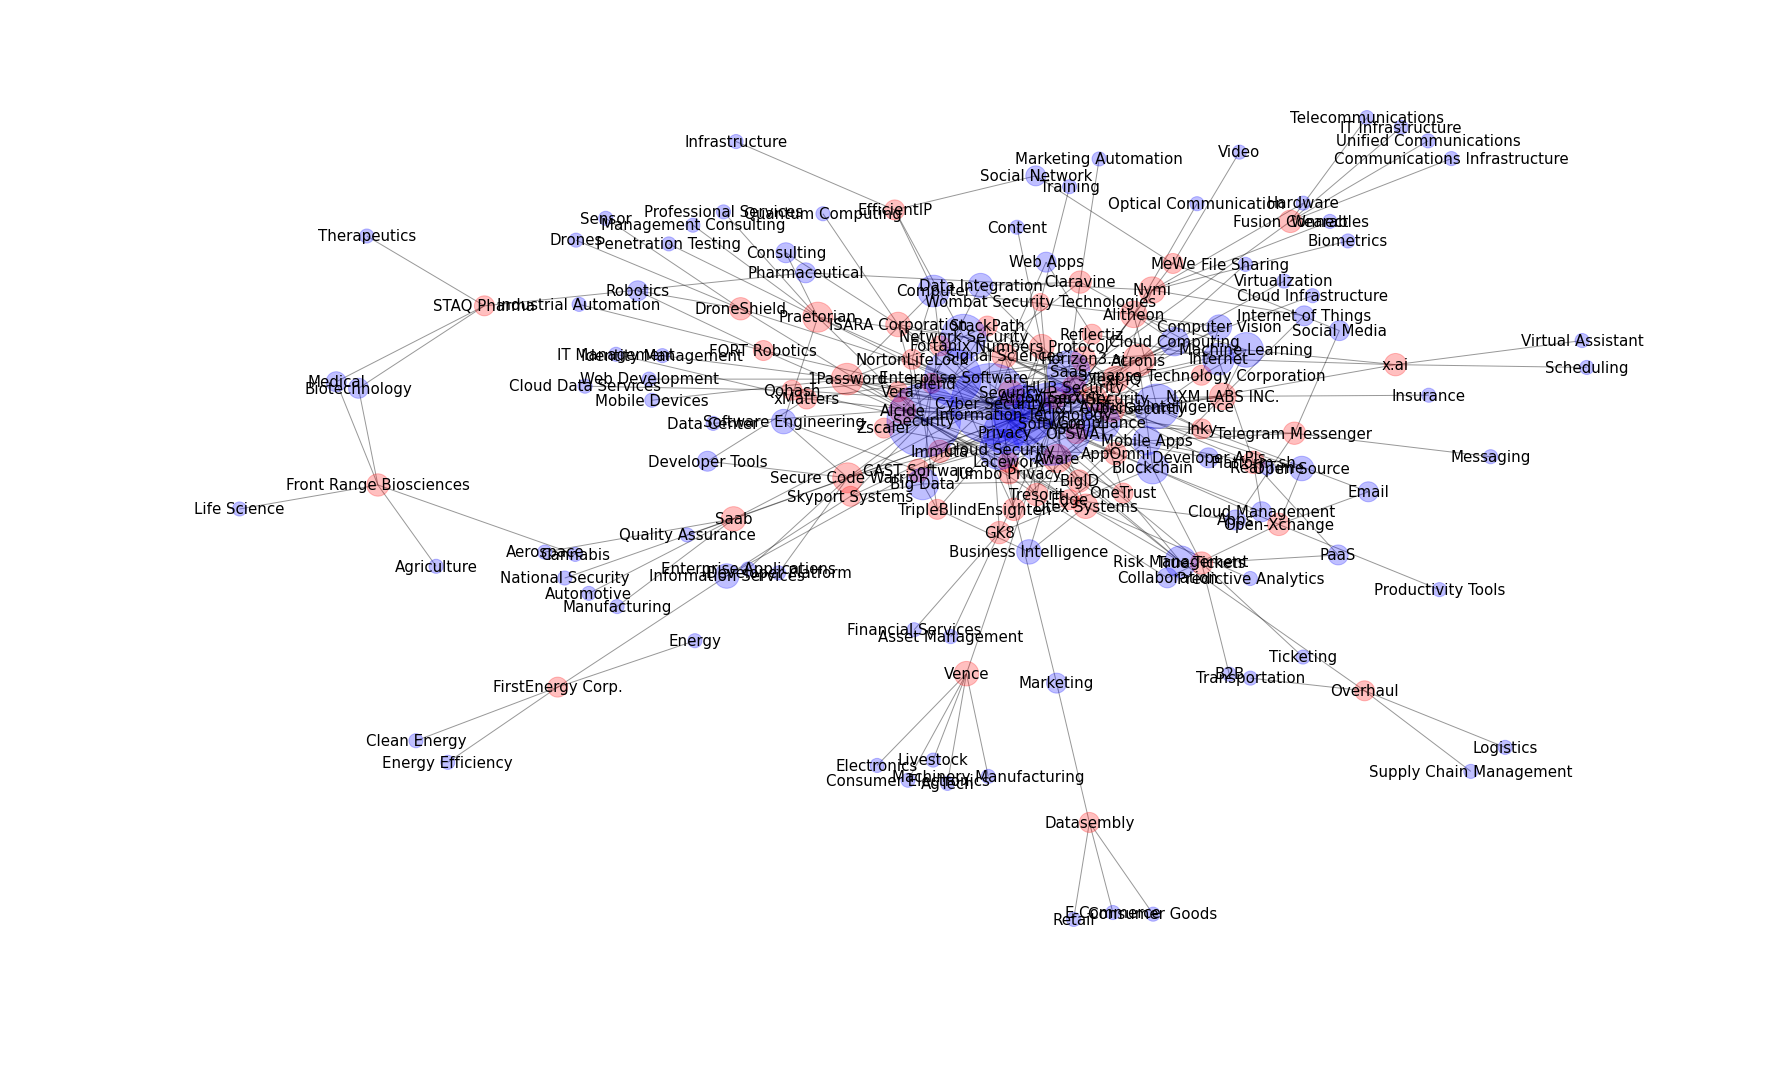

In [28]:
pos2 = plot_bipartite_graph(B, small_degree=False, percentage=percentagee)
plt.savefig(f'plots_net/network_{str(percentagee)}_{str(len(df))}.pdf')
plt.savefig(f'plots_net/network_{str(percentagee)}_{str(len(df))}.png')

In [29]:
pos3 = pos2 # sarebbe un altro ancora ma per ora non serve

In [30]:
honey = [
    'Market Research',
    'Honeywell International',
    'E-Learning',
    'EdTech',
    'Electronics',
    'Service Industry',
    'Aerospace',
    'Manufacturing',
    'Innovation Management'
]

In [35]:
for h in honey:
    position = pos3[h]
    position[1] = position[1]- 0.2
    pos3[h] = position

KeyError: 'Market Research'

In [36]:
mapping = {
    'Swiss Security Solutions LLC': "Swiss Security Solutions", 
    'fitchain': "Fitchain",
    'Cloud Computing':'Cloud \n Computing',
    'Law Enforcement':'Law \n Enforcement',
    'Physical Security':'Physical \n Security',
    'National Security':'National \n Security',
    'Management Consulting': 'Management \n Consulting'
}

B = nx.relabel_nodes(B, mapping)

In [37]:
pos3['Management \n Consulting'] = pos3['Management Consulting']
pos3.pop('Management Consulting')

array([0.01376955, 0.30874531])

In [ ]:
h = 'Law \n Enforcement'
position = pos3[h]
position[0] = position[0] + 0.05
pos3[h] = position

In [ ]:
plot_bipartite_graph1(pos3, B, small_degree=False, percentage=percentagee)

plt.savefig(f'plots_net/network_finished.pdf')
plt.savefig(f'plots_net/network_finished.png')

In [ ]:
def plot_bipartite_graph1(pos, G, small_degree=True, percentage=10, circular=False):

    set1 = [node for node in G.nodes() if G.nodes[node]['bipartite']==0]
    set2 = [node for node in G.nodes() if G.nodes[node]['bipartite']==1]

    if small_degree == False: # don't plot nodes with low number of edges
        to_delete = filter_dict(G, percentage, set1, set2)

        G_filtered = G.copy()
        G_filtered.remove_nodes_from(to_delete)
        G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

        plot_bipartite_graph1(pos, G_filtered, small_degree=True, percentage=percentage, circular=circular)
        
        return

    if len(set1)>=20:
        plt.figure(1,figsize=(25,15))
    else: 
        plt.figure(1,figsize=(19,13)) 
    
    plt.axis('off')



    if "Social Recruiting" in G.nodes():
        G.remove_node("Social Recruiting")
    if "Mobile" in G.nodes():
        G.remove_node("Mobile")
    if "Sales" in G.nodes():
        G.remove_node("Sales")
    if "Analytics" in G.nodes():
        G.remove_node("Analytics")
    if "Government" in G.nodes():
        G.remove_node("Government")
    if "Education" in G.nodes():
        G.remove_node("Education")
    if "Personalization" in G.nodes():
        G.remove_node("Personalization")
    if "Military" in G.nodes():
        G.remove_node("Military")

    G.remove_node("Virtualization")

    # company, value = bipartite.sets(G)
    # subsituted with:
    company = [node for node in G.nodes() if G.nodes[node]['bipartite']==0]
    value = [node for node in G.nodes() if G.nodes[node]['bipartite']==1]

    # calculate degree centrality
    companyDegree = nx.degree(G, company) 
    valueDegree = nx.degree(G, value)


    # nodes
    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=company,
                           node_color='r',
                           node_size=[v * 100 for v in dict(companyDegree).values()],
                           alpha=0.25,
                           label=company)

    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=value,
                           node_color='b',
                           node_size=[v * 200 for v in dict(valueDegree).values()],
                           alpha=0.25,
                           label=value)

    nx.draw_networkx_labels(G, pos, {n: n for n in company}, font_size=20)
    nx.draw_networkx_labels(G, pos, {n: n for n in value}, font_size=20)

    # edges
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.4)


    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()

    return 


In [ ]:
"""plot_bipartite_graph(B, small_degree=False, circular=True, percentage=percentagee)
plt.savefig(f'plots_net/network_{str(percentagee)}_circ_{str(len(df))}.pdf')
plt.savefig(f'plots_net/network_{str(percentagee)}_circ_{str(len(df))}.png')"""

In [ ]:
[company_degree, tech_degree] = degree_bip(B)

In [ ]:
print(f"We have {len(company_degree)} companies and {len(tech_degree)} technologies")

In [ ]:
# sort by value
company_degree_sorted = dict(sorted(company_degree.items(), key=lambda item: item[1], reverse=True))
tech_degree_sorted = dict(sorted(tech_degree.items(), key=lambda item: item[1], reverse=True))

# only maximum 
num_max = 10


# check we don't go out of range
if len(company_degree)<num_max or len(tech_degree)<num_max:
    minn = min(len(company_degree), len(tech_degree))
    num_max = minn-1

def limit_value(x, num_max_perc):
    return list(x.values())[num_max_perc]

company_degree_max = {k: company_degree_sorted[k] for k in list(company_degree_sorted.keys())[:num_max]}
tech_degree_max = {k: tech_degree_sorted[k] for k in list(tech_degree_sorted.keys())[:num_max]}


In [ ]:
plt.barh(list(company_degree_max.keys()), company_degree_max.values(), color='g')
plt.grid(True)
plt.show()

In [ ]:
plt.barh(list(tech_degree_max.keys()), tech_degree_max.values(), color='g')
plt.grid(True)
plt.show()

In [ ]:
# companies' degree 
dict_companies = insert_data_classes(dict_companies, dict(company_degree), 'degree')

In [ ]:
# technologies' degree
dict_tech = insert_data_classes(dict_tech, dict(tech_degree), 'degree')

In [ ]:
a = list(company_degree.values())
b = list(tech_degree.values())
degrees_a = range(len(a))
degrees_b = range(len(b))

m=0
plt.figure(figsize=(12, 8)) 
plt.loglog(degrees_a[m:], a,'go-', label='Companies degree') 
plt.loglog(degrees_b[m:], b,'ro-', label='Technologies degree') 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
sns.set(style="darkgrid")
sns.displot(a, color="blue", label="Companies degree", kde=True)
plt.xlabel("Companies degree")
sns.displot(b, color="red", label="Technologies degree", kde=True)
plt.xlabel("Technologies degree")
plt.show()

## Rank <a class="anchor" id="rank"></a>

In [210]:
from networkx.algorithms.bipartite.matrix import biadjacency_matrix

In [211]:
set0 = extract_nodes(B, 0)
set1 = extract_nodes(B, 1)

# adjacency matrix of bipartite graph
adj_matrix = biadjacency_matrix(B, set0, set1)

In [212]:
adj_matrix_dense = adj_matrix.todense()

**Representation**

In [213]:
a = np.squeeze(np.asarray(adj_matrix_dense))
#a.sum(axis=1)

In [214]:
# import functions from py file 

import functions.fun_meth_reflections
reload(functions.fun_meth_reflections)
from functions.fun_meth_reflections import zero_order_score, Gct_beta, Gtc_alpha, make_G_hat, next_order_score, generator_order_w
from functions.fun_meth_reflections import M_test_triangular, w_stream, find_convergence, rank_df_class, w_star_analytic

In [215]:
# M is the array version of the matrix adj_matrix_dense:
M = np.squeeze(np.asarray(adj_matrix_dense))

### Triangularize matrix

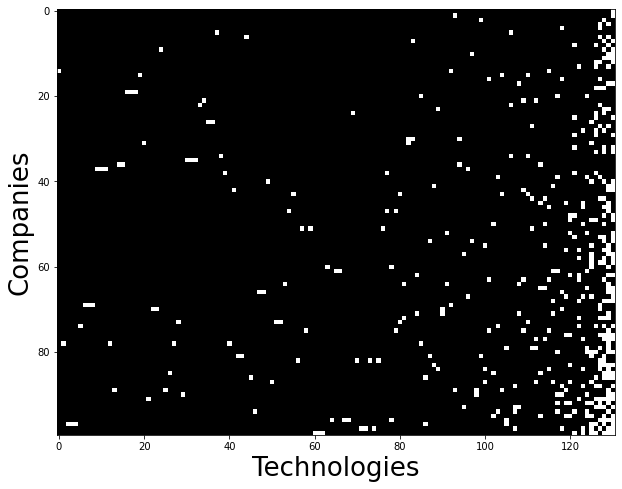

In [216]:
M_test_triangular(adj_matrix_dense)

### Zero order score

These are an $w_{c}$ editor-vector which is the sums of articles edited by each editor. Or the article-vector $w_{p}$, which is the sum of editors contributing to each article.

\begin{cases}
 w_{c}^{(0)} = \sum_{p=1}^{N_{p}} M \equiv k_c\\[7pt]
 w_{p}^{(0)} = \sum_{c=1}^{N_{c}} M \equiv k_p
\end{cases}

In [217]:
k_c, k_t = zero_order_score(M)

### G - transition probability function

Depending on $\alpha$ and $\beta$ we non-linearly weight based on the Zeroth order iterations. 

\begin{cases}
G_{ct}(\beta) = \frac{M_{ct} k_{c}^{-\beta}}{\sum_{c' = 1}^{N_c} M_{c't} k_{c'}^{-\beta}}\\[10pt]
G_{tc}(\alpha) = \frac{M_{ct} k_{t}^{-\alpha}}{\sum_{t' = 1}^{N_t} M_{ct'} k_{t'}^{-\alpha}}.\\\end{cases}

### Higher cases

The first order $w^{1}_c$ is the sum of the articles touched, but weighted by the Zeroth order article-vector (and the $G$ term). So if you've edited better articles that counts. And $w^{1}_c$ is the sum of editors touching, but weighted by the Zeroth order editor-vector (and $G$). So if you're touched by better editors that's also being considered. 

Beyond the first order interpretation for the higher orders is difficult.

\begin{cases}
w^{(n+1)}_c (\alpha,\beta) = \sum_{t=1}^{N_p}  G_{ct}(\beta) \,w^{(n)}_t (\alpha,\beta)\\[7pt]
w^{(n+1)}_t (\alpha,\beta) = \sum_{c=1}^{N_c}  G_{tc}(\alpha) \, w^{(n)}_c (\alpha,\beta)\\
\end{cases}

convergence_comp = find_convergence(M, alpha=0.5, beta=0.5, fit_or_ubiq='fitness', do_plot=True)

plt.savefig(f'plots/CSV_company_rank_evolution_{str(len(df))}.pdf')
plt.savefig(f'plots/CSV_company_rank_evolution_{str(len(df))}.png')#### Companies

converge at 142
132


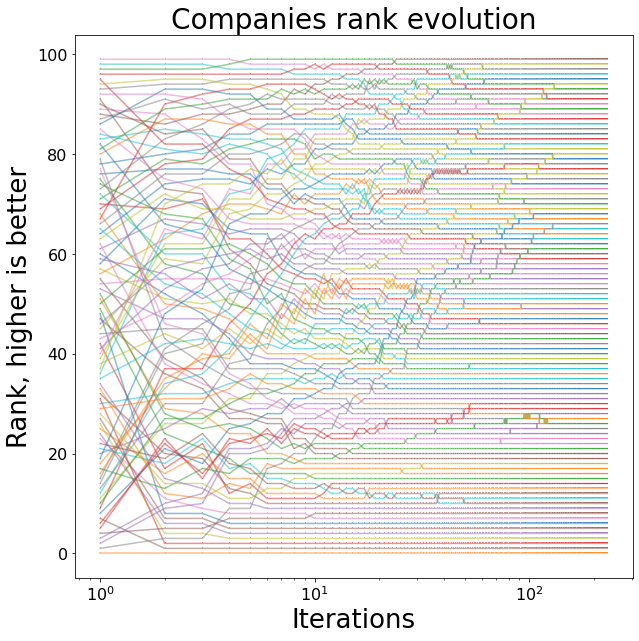

In [218]:
convergence_comp = find_convergence(M, alpha=0.5, beta=0.5, fit_or_ubiq='fitness', do_plot=True)

plt.savefig(f'plots/CSV_company_rank_evolution_{str(len(df))}.pdf')
plt.savefig(f'plots/CSV_company_rank_evolution_{str(len(df))}.png')

In [219]:
df_final_companies, dict_companies = rank_df_class(convergence_comp, dict_companies)

In [220]:
convergence_comp

{'fitness': array([3.20928638, 3.33001026, 2.1962021 , 3.7250347 , 3.09483038,
        2.54925064, 7.73939335, 4.00042264, 3.50986027, 7.20116329,
        6.86888591, 5.20809901, 3.51104005, 2.09629719, 4.29938573,
        3.70255397, 1.85994495, 6.94514889, 1.56176334, 8.70740896,
        3.73879217, 2.35749066, 3.45408442, 8.1965433 , 4.49475744,
        2.43842428, 3.70677725, 8.84720284, 6.38371743, 5.05474342,
        4.86008641, 3.77378318, 5.58478502, 7.28367545, 1.65079286,
        2.05102104, 4.17832055, 6.18603481, 5.52242225, 3.29917003,
        1.85391255, 2.30334583, 2.6838902 , 3.        , 2.96192275,
        4.59449227, 7.8505408 , 8.26848778, 9.1932905 , 3.9652684 ,
        8.67799528, 4.97904874, 8.3932137 , 1.3407947 , 2.89894622,
        9.87236452, 2.77270755, 2.93484945, 8.52326657, 3.44952885,
        6.27641705, 2.05135877, 2.9362012 , 4.54240093, 3.8539127 ,
        1.22196532, 4.51699315, 5.95290344, 6.08605314, 4.87802981,
        3.58746941, 3.86140019, 7.748

In [221]:
# relative rank
df_final_companies['final_rank_normlized'] = df_final_companies['final_rank']/np.max(list(df_final_companies['final_rank']))*10
n = np.max(df_final_companies['rank_CB']) + 1
df_final_companies['rank_CB_normlized'] = n - df_final_companies['rank_CB']

df_final_companies['TeckRank_int'] = df_final_companies.index + 1.0

In [222]:
df_final_companies

,initial_position,final_configuration,degree,final_rank,rank_CB,final_rank_normlized,rank_CB_normlized,TeckRank_int
0,0,Oort,0,0.748,20198.0,0.757699,6349.0,1.0
1,7,vChain,0,1.222,15265.0,1.237844,11282.0,2.0
2,31,ForAllSecure,0,1.341,12223.0,1.358387,14324.0,3.0
3,26,Synack,0,1.562,3485.0,1.582253,23062.0,4.0
4,24,Threatcare,0,1.651,8055.0,1.672407,18492.0,5.0
...,...,...,...,...,...,...,...,...
95,64,Fusion Connect,0,8.678,12159.0,8.790519,14388.0,96.0
96,36,FirstEnergy Corp.,0,8.707,3515.0,8.819895,23032.0,97.0
97,87,Saab,0,8.847,5577.0,8.96171,20970.0,98.0
98,39,Datasembly,0,9.193,11925.0,9.312196,14622.0,99.0


In [223]:
df_spearman = df_final_companies[["TeckRank_int", "rank_CB_normlized"]]
df_spearman = df_spearman.astype(float)
df_spearman["name"] = df_final_companies['final_configuration']
df_spearman.set_index("name")

,TeckRank_int,rank_CB_normlized
name,,
Oort,1.0,6349.0
vChain,2.0,11282.0
ForAllSecure,3.0,14324.0
Synack,4.0,23062.0
Threatcare,5.0,18492.0
...,...,...
Fusion Connect,96.0,14388.0
FirstEnergy Corp.,97.0,23032.0
Saab,98.0,20970.0


In [224]:
df_spearman

,TeckRank_int,rank_CB_normlized,name
0,1.0,6349.0,Oort
1,2.0,11282.0,vChain
2,3.0,14324.0,ForAllSecure
3,4.0,23062.0,Synack
4,5.0,18492.0,Threatcare
...,...,...,...
95,96.0,14388.0,Fusion Connect
96,97.0,23032.0,FirstEnergy Corp.
97,98.0,20970.0,Saab
98,99.0,14622.0,Datasembly


In [225]:
len(df)

100

In [227]:
# save df
name = "csv_results/complete_companies_" + str(len(df)) + ".csv"
df_final_companies.to_csv(name, index = False, header=True)

df_spearman["rank_CB_normlized"]**Sperman correlation**

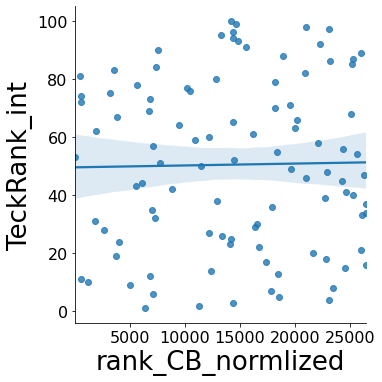

In [228]:
sns.lmplot(x="rank_CB_normlized", y="TeckRank_int", data=df_spearman)
plt.show()

In [229]:
df_spearman.corr(method='spearman')

,TeckRank_int,rank_CB_normlized
TeckRank_int,1.000000,0.016244
rank_CB_normlized,0.016244,1.000000


#### Technologies

converge at 164
154


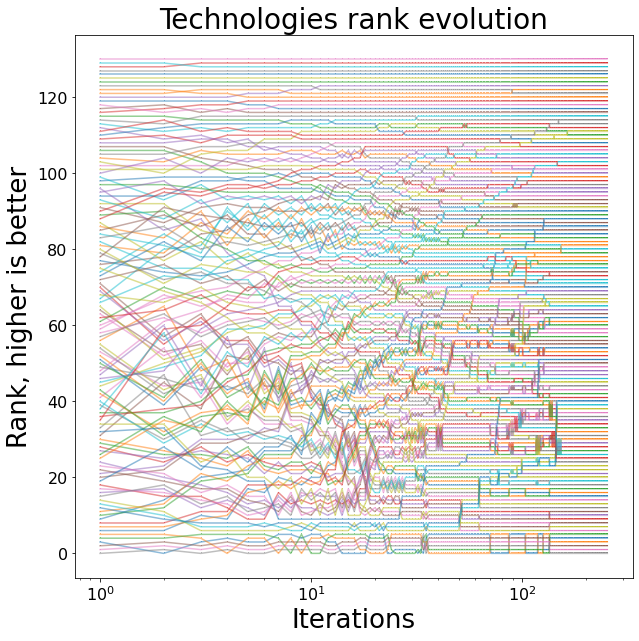

In [230]:
convergence_tech = find_convergence(M, alpha=0.5, beta=0.5, fit_or_ubiq='ubiquity', do_plot=True)

plt.savefig(f'plots/CSV_tech_rank_evolution_{str(len(df))}.pdf')
plt.savefig(f'plots/CSV_tech_rank_evolution_{str(len(df))}.png')

In [231]:
df_final_tech, dict_tech = rank_df_class(convergence_tech, dict_tech)

In [232]:
df_final_tech

,initial_position,final_configuration,degree,final_rank
0,0,Wellness,0,1.0
1,1,Cosmetics,0,1.0
2,2,Beauty,0,1.0
3,5,Home Renovation,0,1.0
4,3,Home Improvement,0,1.0
...,...,...,...,...
126,126,Network Security,0,10.505
127,127,Information Technology,0,12.08
128,129,Security,0,14.352
129,128,Software,0,15.035


In [233]:
# save df
name = "csv_results/complete_tech_" + str(len(df)) + ".csv"

df_final_tech.to_csv(name, index = False, header=True)

In [245]:
# import functions from py file 

import functions.fun_meth_reflections
reload(functions.fun_meth_reflections)
from functions.fun_meth_reflections import zero_order_score, Gct_beta, Gtc_alpha, make_G_hat, next_order_score, generator_order_w
from functions.fun_meth_reflections import M_test_triangular, w_stream, find_convergence, rank_df_class, w_star_analytic

## Parameters calibration with exogenous variables.  <a class="anchor" id="pal_cal"></a>

An essential step is the calibration of $alpha$ and $beta$, i.e. find the *optimal* parameters that maximise our correlation between model and actual. 

We decide to perform just a **grid search**, defining a way to compare our list rankings using the Spearman method from `scipy.stats`. So, we define a landscape, $[-2,2] \times [-2,2]$ with resolution $50 \times 50$ for istance, and evaluate at all those points (using the analytic method). Finally we will return the top correlation we found.

NB: also for this step, we take inspiration by the work by Klein, Maillart, and Chuang.

In [235]:
#rank_comparison(a_ranks_sorted, b_ranks_sorted, do_plot=False)

In [250]:
# w analytic for companies and technologies
w_star_analytic_c, dict_companies = w_star_analytic(M, alpha=0.5, beta=0.5, ua='Companies', dict_class=dict_companies)
w_star_analytic_t, dict_tech = w_star_analytic(M, alpha=0.5, beta=0.5, ua='Technologies', dict_class=dict_tech)

## note! we try without sorting. then see what changes sorting

In [251]:
#sorted(w_star_analytic_c.iteritems(), key=operator.itemgetter(1))

In [263]:
# import functions from py file 

import functions.fun_external_factors
reload(functions.fun_external_factors)
from functions.fun_external_factors import rank_comparison, calibrate_analytic, create_exogenous_rank

**Exogenous factor (benchmark)**

Attention a come hai aggiornato i dizionari

In [264]:
filename = "classes/dict_companies_cybersecurity_100.pickle"

with open(filename, 'rb') as f:
    dict_companies = pickle.load(f)

In [265]:
preferences = {"previous_investments":30,
              "crunchbase_rank":70}

{'spearman': 0.40671355194710473,
 'alpha': 0.24,
 'beta': 1.92,
 'ua': 'Companies'}

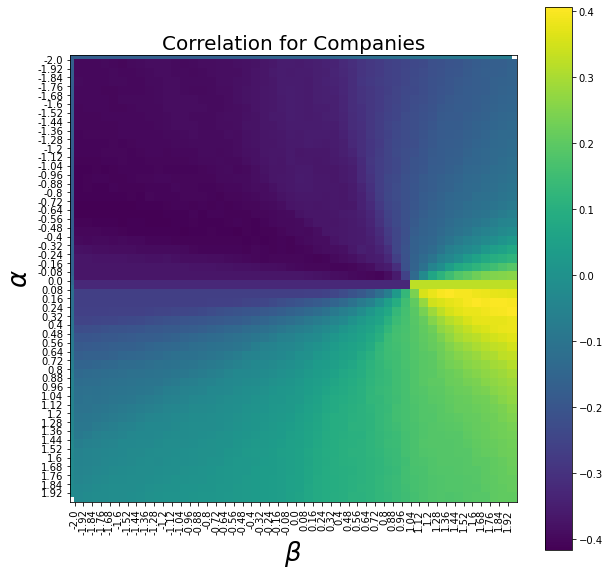

In [266]:
calibrate_analytic(M=M,
                   ua='Companies',
                   dict_class=dict_companies, 
                   exogenous_rank=create_exogenous_rank('Companies', dict_companies, preferences), 
                   index_function=lambda x: (x-25)/12.5,
                   title='Correlation for Companies',
                   do_plot=True)

In [267]:
preferences = {"previous_investments":100,
              "crunchbase_rank":0}

{'spearman': 0.27745388998837756,
 'alpha': -0.16,
 'beta': 0.16,
 'ua': 'Companies'}

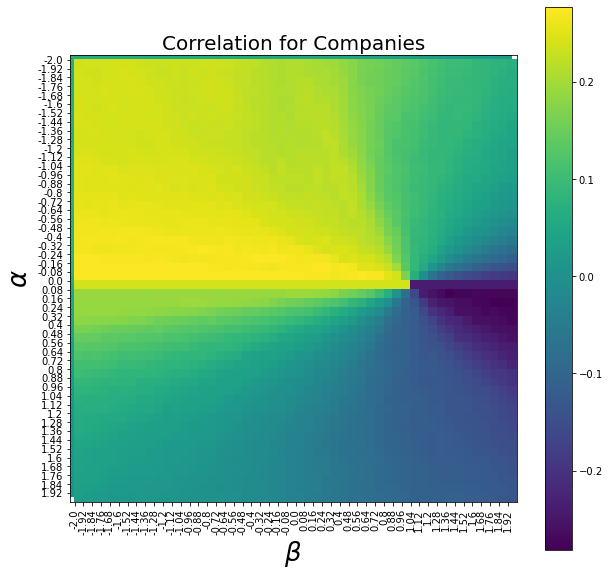

In [268]:
calibrate_analytic(M=M,
                   ua='Companies',
                   dict_class=dict_companies, 
                   exogenous_rank=create_exogenous_rank('Companies', dict_companies, preferences), 
                   index_function=lambda x: (x-25)/12.5,
                   title='Correlation for Companies',
                   do_plot=True)

## Save dictionaries

In [133]:
# Save dictionaries in a pickle files
if flag_cybersecurity==False: # all fields
    name_file_com = "classes/dict_companies_" + str(len(dict_companies)) + ".pickle"
    name_file_tech = "classes/dict_tech_" + str(len(dict_tech)) + ".pickle"
else: # only companies in cybersecurity
    name_file_com = "classes/dict_companies_cybersecurity_" + str(len(dict_companies)) + ".pickle"
    name_file_tech = "classes/dict_tech_cybersecurity_" + str(len(dict_tech)) + ".pickle"

# companies
with open(name_file_com, "wb") as f:
    pickle.dump(dict_companies, f)

#technologies
with open(name_file_tech, "wb") as f:
    pickle.dump(dict_tech, f)